In [1]:
import numpy as np
import pandas as pd

from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import itertools, scipy
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

import cell2cell as c2c

%matplotlib inline

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


# 3D Map

In [2]:
atlas = pd.read_csv('../Data/Digital-3D-Map/Celegans_L1_3D_Atlas_CellTypes.csv')
atlas = atlas.loc[~atlas['Cell Type'].isnull()].reset_index(drop=True)

In [3]:
atlas.head()

,Cell,Lineage Name,Description,Cell2,Name2,X,Y,Z,Cell Type
0,ADEshL,AB arppaaaa,Anterior deirid sheath,ADESHL,ABARPPAAAA,11.134,84.340,12.852,Am/PH_sheath_cells
1,ADEshR,AB arpppaaa,Anterior deirid sheath,ADESHR,ABARPPPAAA,16.990,85.075,13.130,Am/PH_sheath_cells
2,ALML,AB.arppaappa,"Anterior lateral microtubule cell, touch receptor",ALML,ABARPPAAPPA,11.759,120.005,16.090,Touch_receptor_neurons
3,ALMR,AB arpppappa,"Anterior lateral microtubule cell, touch receptor",ALMR,ABARPPPAPPA,16.467,119.037,15.870,Touch_receptor_neurons
4,ALNL,AB plapappppap,Neuron associated with ALM,ALNL,ABPLAPAPPPPAP,12.884,199.753,15.437,Oxygen_sensory_neurons


# Load LR list

In [4]:
lr_pairs = pd.read_csv('../Data/PPI-Networks/Celegans-GA-Selected-LR-pairs.csv')

In [5]:
lr_pairs = lr_pairs.sort_values(by=['LR Function', 'index'])

In [6]:
lr_pairs.head()

,Ligand_WB,Receptor_WB,Ligand_symbol,Receptor_symbol,score,index,LR Function,L Function,R Function,Ligand_desc,Receptor_desc
1,WBGene00002881,WBGene00006894,let-756,ver-1,1.0,7,Canonical RTK-Ras-ERK signaling,FGF,fms-related tyrosine kinase 1,Is an ortholog of human FGF16 (fibroblast grow...,Is an ortholog of human FLT1 (fms related rece...
2,WBGene00000527,WBGene00001687,cle-1,gpn-1,1.0,13,Cell adhesion,Collagen,Glypican (co-receptor) Frizzled homolog,Is an ortholog of human COL15A1 (collagen type...,Is an ortholog of human GPC1 (glypican 1) and ...
3,WBGene00002280,WBGene00003930,let-2,pat-3,1.0,26,Cell adhesion,Collagen,Integrin,Is an ortholog of human COL4A5 (collagen type ...,Is an ortholog of human ITGB1 (integrin subuni...
6,WBGene00000674,WBGene00016104,col-99,ddr-1,1.0,35,Cell adhesion,Collagen,Discoidin domain receptor,Is an ortholog of human COL13A1 (collagen type...,Is an ortholog of human DDR1 (discoidin domain...
8,WBGene00003738,WBGene00004215,nid-1,ptp-3,1.0,46,Cell adhesion,Nidogen,LAR-RPTP,Is an ortholog of human NID1 (nidogen 1) and N...,Is an ortholog of human PTPRD (protein tyrosin...


# LR information

In [7]:
labels_dict = dict()
for pair in lr_pairs.iterrows():
    original = (pair[1]['Ligand_WB'], pair[1]['Receptor_WB'])
    new = pair[1]['Ligand_symbol']+' / '+pair[1]['Receptor_symbol']
    labels_dict[original] = new 

In [8]:
functions = ['Cell migration', 'Wnt signaling', 'Cell adhesion', 'Notch signaling',
       'Insulin signaling', 'TGF-B signaling', 'Hedgehog signaling',
       'Mechanosensory mechanism', 'Canonical RTK-Ras-ERK signaling',
       'Neuronal communication', 'Eph receptor signaling',
       'Epidermal development', 'Lipid homeostasis', 'Immune response',
       'Trypsin-like proteolysis', 'Longevity', 'PCP pathway',
       'Receptor-Mediated-Endocytosis', 'Stress response', 'Apoptosis']
function_colors = c2c.utils.get_colors_from_labels(functions, cmap='tab20')

func_color_dict = dict()
row_cols = []
for idx, row in lr_pairs.iterrows():
    name = str(row['Ligand_symbol']) + ' / ' + str(row['Receptor_symbol'])
    func = str(row['LR Function'])
    func_color_dict[name] = function_colors[func]
    row_cols.append((name, function_colors[func]))
row_cols = pd.DataFrame.from_records(row_cols, columns=['LR', 'Function']).set_index('LR')

# Cell-Cell Interactions

**Setups**

In [9]:
data_folder = '../Data/'

In [10]:
files = dict()
files['rnaseq'] = data_folder + '/RNA-Seq/Celegans_RNASeqData_Cell.xlsx'
files['metadata'] = data_folder + '/RNA-Seq/Celegans_cell_metadata.tsv'
files['ppi'] = data_folder + '/PPI-Networks/Celegans-GA-Selected-LR-pairs.csv'
files['phenotype'] = data_folder + '/Digital-3D-Map/Celegans_Physical_Distances_Min.csv'
files['output_folder'] = '../Figures/'

In [11]:
rnaseq_setup = dict()
rnaseq_setup['gene_col'] = 'gene_id'
rnaseq_setup['drop_nangenes'] = True
rnaseq_setup['log_transform'] = False

meta_setup = dict()
meta_setup['sample_col'] = '#SampleID'
meta_setup['group_col'] = 'Groups'

ppi_setup = dict()
ppi_setup['protein_cols'] = ['Ligand', 'Receptor']

cutoff_setup = dict()
cutoff_setup['type'] = 'constant_value'
cutoff_setup['parameter'] = 10 # TPM

analysis_setup = dict()
analysis_setup['communication_score'] = 'expression_thresholding'
analysis_setup['cci_score'] = 'bray_curtis'
analysis_setup['cci_type'] = 'undirected'

**RNA-seq**

In [12]:
rnaseq_data = c2c.io.load_rnaseq(rnaseq_file=files['rnaseq'],
                                 gene_column=rnaseq_setup['gene_col'],
                                 drop_nangenes=rnaseq_setup['drop_nangenes'],
                                 log_transformation=rnaseq_setup['log_transform'],
                                 format='auto')

Opening RNAseq datasets from ../Data//RNA-Seq/Celegans_RNASeqData_Cell.xlsx
../Data//RNA-Seq/Celegans_RNASeqData_Cell.xlsx was correctly loaded


**Metadata**

In [13]:
meta = c2c.io.load_metadata(metadata_file=files['metadata'],
                            rnaseq_data=rnaseq_data,
                            sample_col=meta_setup['sample_col'],
                            format='auto')

../Data//RNA-Seq/Celegans_cell_metadata.tsv was correctly loaded


**PPI Network**

In [14]:
ppi_data = c2c.io.load_ppi(ppi_file=files['ppi'] ,
                           interaction_columns=['Ligand_WB', 'Receptor_WB'],
                           sort_values=['LR Function', 'index'],
                           #score='score',
                           format='auto')

Opening PPI datasets from ../Data//PPI-Networks/Celegans-GA-Selected-LR-pairs.csv
../Data//PPI-Networks/Celegans-GA-Selected-LR-pairs.csv was correctly loaded
Removing bidirectionality of PPI network
Simplying PPI network


In [15]:
print('Ligands: {}\nReceptors: {}\nPairs: {}'.format(len(ppi_data['A'].unique()),
                                                     len(ppi_data['B'].unique()),
                                                     len(ppi_data[['A', 'B']].values)
                                                    )
     )

Ligands: 30
Receptors: 29
Pairs: 37


**Analysis**

In [16]:
interaction_space = c2c.analysis.basic_pipeline(rnaseq_data=rnaseq_data,
                                                ppi_data=ppi_data,
                                                cutoff_setup=cutoff_setup,
                                                analysis_setup=analysis_setup,
                                                verbose=False)

In [17]:
interaction_space.compute_pairwise_communication_scores(verbose=False,
                                                        ref_ppi_data=ppi_data,
                                                        cci_type='directed')
interaction_matrix = interaction_space.interaction_elements['communication_matrix']

In [18]:
interaction_matrix.index = interaction_matrix.index.map(labels_dict)

# Body sections of *C. elegans*

**Assign Major Cell type to each Cell type**

In [19]:
atlas['Major Cell Type'] = atlas['Cell Type'].apply(lambda x: meta.loc[meta['#SampleID'] == x] \
                                                                  ['Groups'].values[0])

## Antero-posterior

In [20]:
worm_length = atlas['Y'].max() - atlas['Y'].min()

In [21]:
print('The length of the worm is {} um'.format(int(worm_length)))

The length of the worm is 205 um


In [22]:
plane_number = 9 # Number of bins = plane_number - 1

**Coordinates Information**

In [23]:
min_y = atlas['Y'].min()
max_y = atlas['Y'].max()
range_y =  max_y - min_y

In [24]:
print('Min position in Y-axis: {}'.format(min_y))
print('Max position in Y-axis: {}'.format(max_y))
print('Range in Y-axis: {}'.format(range_y))

Min position in Y-axis: 16.674
Max position in Y-axis: 221.96599999999998
Range in Y-axis: 205.29199999999997


**Generate Bins**

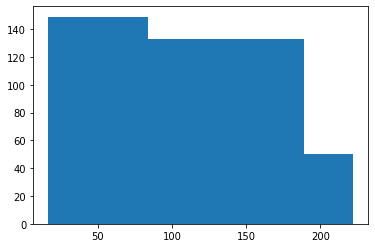

In [25]:
counts = plt.hist(atlas['Y'].values, 
                  bins=[min_y, 84, 189, max_y]
                  #bins=plane_number-1
                 )

In [26]:
counts[1][-1] += 1.0

In [27]:
atlas['Z'].describe()

count    332.000000
mean      13.028699
std        2.578641
min        8.259000
25%       11.123250
50%       12.818000
75%       15.157500
max       18.027000
Name: Z, dtype: float64

**Assign Bins**

In [28]:
mid_point_z = (atlas['Z'].max() - atlas['Z'].min())/2.0 +  atlas['Z'].min()

In [29]:
atlas['Bins'] = np.digitize(atlas['Y'].values, counts[1], right=False)    

In [30]:
atlas['Bins_dorsoventral'] = atlas.apply(lambda row: str(row['Bins']) + '_d' if row['Z'] <= mid_point_z \
                                         else str(row['Bins']) + '_v',
                                         axis=1)

In [31]:
atlas.head()

,Cell,Lineage Name,Description,Cell2,Name2,X,Y,Z,Cell Type,Major Cell Type,Bins,Bins_dorsoventral
0,ADEshL,AB arppaaaa,Anterior deirid sheath,ADESHL,ABARPPAAAA,11.134,84.340,12.852,Am/PH_sheath_cells,Excretory/Socket/Sheath cells,2,2_d
1,ADEshR,AB arpppaaa,Anterior deirid sheath,ADESHR,ABARPPPAAA,16.990,85.075,13.130,Am/PH_sheath_cells,Excretory/Socket/Sheath cells,2,2_d
2,ALML,AB.arppaappa,"Anterior lateral microtubule cell, touch receptor",ALML,ABARPPAAPPA,11.759,120.005,16.090,Touch_receptor_neurons,Neurons,2,2_v
3,ALMR,AB arpppappa,"Anterior lateral microtubule cell, touch receptor",ALMR,ABARPPPAPPA,16.467,119.037,15.870,Touch_receptor_neurons,Neurons,2,2_v
4,ALNL,AB plapappppap,Neuron associated with ALM,ALNL,ABPLAPAPPPPAP,12.884,199.753,15.437,Oxygen_sensory_neurons,Neurons,3,3_v


**Extract Spatial use of LRs**

In [32]:
lr_list = interaction_matrix.index #.map(labels_dict)
spatial_lr = pd.DataFrame(index=lr_list)
spatial_enr = pd.DataFrame(index=lr_list)

bin_interactions = dict()
for group, df in atlas.groupby('Bins'):
    # Get pairwise interactions per bin
    cells = df['Cell Type'].values.tolist()
    #bin_interactions['Bin-{}'.format(group)] = list(itertools.product(cells, cells))
    bin_interactions['Bin-{}'.format(group)] = c2c.core.interaction_space.generate_pairs(cells=cells,
                                                                                         cci_type='directed',
                                                                                         self_interaction=True,
                                                                                         remove_duplicates=False
                                                                                        )
    # Extract active interactions per bin
    tmp_df = pd.DataFrame()
    for interaction in bin_interactions['Bin-{}'.format(group)]:
        tmp_df = pd.concat([tmp_df, interaction_matrix.loc[:, interaction[0]+';'+interaction[1]]], axis=1)
    if len(tmp_df) != 0:
        spatial_lr['Bin-{}'.format(group)] = tmp_df.mean(axis=1).values
        spatial_enr['Bin-{}'.format(group)] = tmp_df.sum(axis=1).values
    else:
        spatial_lr['Bin-{}'.format(group)] = [0]*len(lr_list)
        spatial_enr['Bin-{}'.format(group)] = [0]*len(lr_list)

**Compute LR enrichment per bin**

In [33]:
across_body = True # Enrichment across body (True) or across bins (False)

if across_body:
    N = sum([len(v) for v in bin_interactions.values()])

    active_lrs = spatial_enr.sum(axis=1).to_dict()

    spatial_pvals = spatial_enr.copy()
    spatial_pvals2 = spatial_enr.copy()

    n = dict()
    for k, v in bin_interactions.items():
        n[k] = len(v)

        def row_fn(row):
            return c2c.stats.fisher_representation(n[k], row[k], N, active_lrs[row.name])
        spatial_pvals[k] = spatial_enr.apply(lambda x: row_fn(x)['pval'][1], axis=1)
        spatial_pvals2[k] = spatial_enr.apply(lambda x: row_fn(x)['pval'][0], axis=1)
else:
    N = spatial_enr.sum(axis=1).sum()

    active_lrs = spatial_enr.sum(axis=1).to_dict()

    spatial_pvals = spatial_enr.copy()
    spatial_pvals2 = spatial_enr.copy()

    n = dict()
    for k, v in bin_interactions.items():
        n[k] = spatial_enr.sum(axis=0)[k]

        def row_fn(row):
            return c2c.stats.fisher_representation(n[k], row[k], N, active_lrs[row.name])
        spatial_pvals[k] = spatial_enr.apply(lambda x: row_fn(x)['pval'][1], axis=1)
        spatial_pvals2[k] = spatial_enr.apply(lambda x: row_fn(x)['pval'][0], axis=1)

In [34]:
# Number of pairs of cells using each LR pair per bin
spatial_enr.head()

,Bin-1,Bin-2,Bin-3
let-756 / ver-1,196.0,168.0,42.0
cle-1 / gpn-1,570.0,3024.0,132.0
let-2 / pat-3,21456.0,17423.0,1850.0
col-99 / ddr-1,3906.0,2600.0,240.0
nid-1 / ptp-3,6048.0,11004.0,450.0


In [35]:
#  Number of pairs of cells per Bin
n

{'Bin-1': 22201, 'Bin-2': 17689, 'Bin-3': 2500}

**FDR correction**

In [36]:
from statsmodels.stats.multitest import fdrcorrection

In [37]:
fdr = 0.01

In [38]:
rej, adj_pvals = fdrcorrection(spatial_pvals.values.flatten(), alpha=fdr)

In [39]:
spatial_pvals = pd.DataFrame(adj_pvals.reshape(spatial_pvals.shape),
                             index=spatial_pvals.index,
                             columns=spatial_pvals.columns)

In [40]:
rej2, adj_pvals2 = fdrcorrection(spatial_pvals2.values.flatten(), alpha=fdr)

In [41]:
spatial_pvals2 = pd.DataFrame(adj_pvals2.reshape(spatial_pvals2.shape),
                             index=spatial_pvals2.index,
                             columns=spatial_pvals2.columns)

In [42]:
raw_pval = False
if raw_pval == False:
    for k in bin_interactions.keys():
        spatial_pvals[k] = spatial_pvals[k].apply(lambda x: 1 if x < fdr else 0)
        spatial_pvals2[k] = spatial_pvals2[k].apply(lambda x: -1. if x < fdr else 0)
else:
    for k in bin_interactions.keys():
        spatial_pvals[k] = spatial_pvals[k].apply(lambda x: -1*np.log10(x) if x != 0 else -1*np.log10(1e-6))
        spatial_pvals2[k] = spatial_pvals2[k].apply(lambda x: -1*np.log10(x) if x != 0 else -1*np.log10(1e-6))

# Visualization

In [43]:
# Colors from figure S14 in C elegans paper (cell type expression data)
lut = {'Coelomocytes': (0.6509803921568628, 0.33725490196078434, 0.1568627450980392), # Brown
       'Neurons': (0.596078431372549, 0.3058823529411765, 0.6392156862745098), # Purple
       'Hypodermal/rectal cells': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), # Green
       'Pharyngeal cells': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), # Blue
       'Intestine': (1.0, 1.0, 0.2), # Yellow
       'Body/muscular cells': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), # Red
       'Excretory/Socket/Sheath cells': (1.0, 0.4980392156862745, 0.0), # Orange
       'Sexual cells': (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)} # Pink

In [44]:
fontname = 'Lato'
tick_size = 12
axis_size = 16
legend_size = 14

inline_rc = dict(mpl.rcParams)
#plt.rcParams["font.family"] = fontname

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  


**Worm & Bins Visualization**

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/e

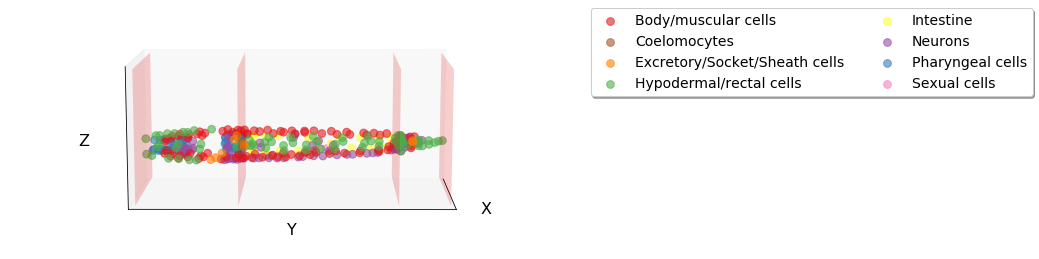

In [45]:
mask = []

NUM_COLORS = len(atlas['Cell Type'].unique())
cm = plt.get_cmap('tab20') # gist_rainbow
fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(111, projection='3d')


xx, zz = np.meshgrid(range(41), range(41))
for bin_val in counts[1]:
    ax.plot_surface(xx, bin_val, zz, alpha=0.2, color='red')

# PLOT BY CELL TYPES
#for i, cell in enumerate(atlas['Cell Type'].unique()):
#    if cell not in mask:
#        cell_type = atlas.loc[atlas['Cell Type'] == cell]
#        ax.scatter(cell_type['X'], cell_type['Y'], cell_type['Z'], color=cm(1.*i/NUM_COLORS), s=60, label=cell)

# PLOT BY CELL GROUPS
for i, cell_type in enumerate(sorted(meta['Groups'].unique())):
    cells = meta.loc[meta.Groups == cell_type]['#SampleID'].values
    cell_cords = atlas.loc[atlas['Cell Type'].isin(cells)]
    ax.scatter(cell_cords['X'],
               cell_cords['Y'],
               cell_cords['Z'],
               color=lut[cell_type],
               s=60,
               label=cell_type,
               alpha=0.6)

             
ax.set_xlim((0, 40))
ax.set_ylim((min_y, max_y)) # (0, 300)
ax.set_zlim((0, 40))


ax.set_xlabel('X', fontsize=axis_size)
ax.set_ylabel('Y', fontsize=axis_size)
ax.set_zlabel('Z', fontsize=axis_size)

#ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = tick_size)

ax.view_init(10, 0.5)
lgd = ax.legend(loc='upper right', bbox_to_anchor=(1.85, 1.025),
                ncol=2, fancybox=True, shadow=True, fontsize=legend_size)

mpl.rcParams.update(inline_rc)
plt.savefig('../Figures/Celegans-3D-Atlas-Dissected.svg', dpi=300,
                bbox_inches='tight')

**Cells in each Bin**

In [46]:
# The ones without 3D localization of cells
excluded_cells = ['Distal_tip_cells',
                  'Sex_myoblasts',
                  'Socket_cells',
                  'Vulval_precursors',
                  'flp-1(+)_interneurons']

In [47]:
template_cols = spatial_lr.columns
template_idx = meta.sort_values(by=['Groups', '#SampleID'])['#SampleID']
data = np.zeros((len(template_idx), len(template_cols)))
template = pd.DataFrame(data, columns=template_cols, index=template_idx)
template.index.name = ''
for bin_id, df in atlas.groupby('Bins'):
    update_df = pd.DataFrame()
    update_df['Bin-{}'.format(bin_id)] = df.groupby('Cell Type')['Cell Type'].count()
    template.loc[update_df.index, 'Bin-{}'.format(bin_id)] = df.groupby('Cell Type')['Cell Type'].count()
    
template = template.loc[~template.index.isin(excluded_cells)]

In [48]:
cell_type_colors = []
for idx, row in meta.sort_values(by=['Groups', '#SampleID']).iterrows():
    if row['#SampleID'] not in excluded_cells:
        cell_type_colors.append(lut[row['Groups']])

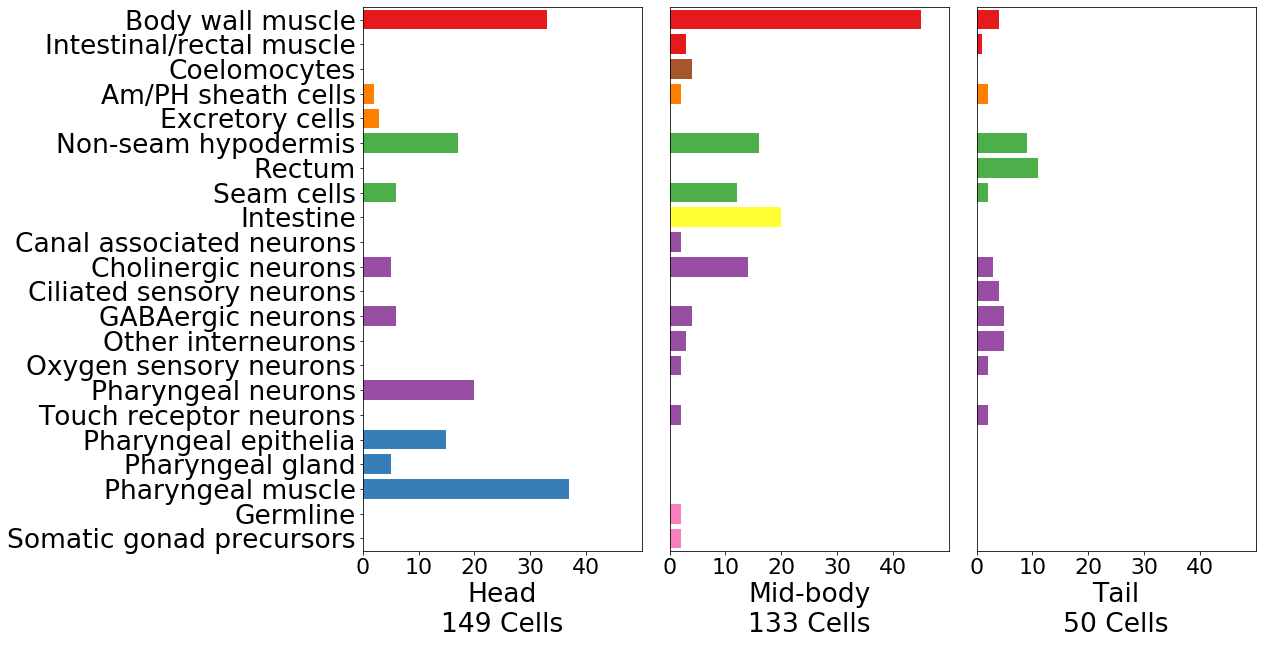

In [62]:
#with sns.axes_style("white"):
fig, axes = plt.subplots(1, len(template_cols), sharey='all', sharex ='all', figsize=(16,10)) #(20,10)
ind = np.arange(template.shape[0])
count = 0
idx_map = {'Bin-1' : 'Head', 'Bin-2': 'Mid-body', 'Bin-3': 'Tail'}
for idx, col in template.T.iterrows():
    bars = axes[count].barh(ind, col.values, color=cell_type_colors)
    axes[count].set_xlabel(idx_map[idx] + '\n{} Cells'.format(int(col.sum())), fontsize=26.5)
    axes[count].tick_params(axis='x', which='major', labelsize=22) # Ex 14
    axes[count].tick_params(axis='y', which='major', labelsize=26.5)
    axes[count].set_yticks(ind) 
    axes[count].set_yticklabels(template.index.str.replace('_', ' '))
    if count != 0:
        axes[count].yaxis.set_ticks_position('none') 
    count += 1

plt.xlim((0,50))
plt.xticks(np.arange(0,50,10))
plt.ylim((-0.5, len(template.index)-0.5))
plt.gca().invert_yaxis()

plt.subplots_adjust(wspace = 0.1)
plt.savefig('../Figures/Spatial-Cell-Distribution.svg',
            dpi=300,
            bbox_inches='tight')

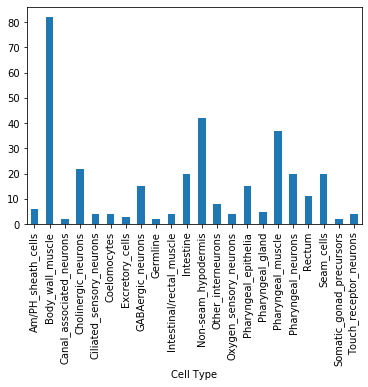

In [50]:
atlas.groupby('Cell Type')['Cell Type'].count().plot(kind='bar')

**Spatial LRs**

In [51]:
import scipy.cluster.hierarchy as hc
import scipy.spatial as sp
from sklearn.metrics import pairwise_distances

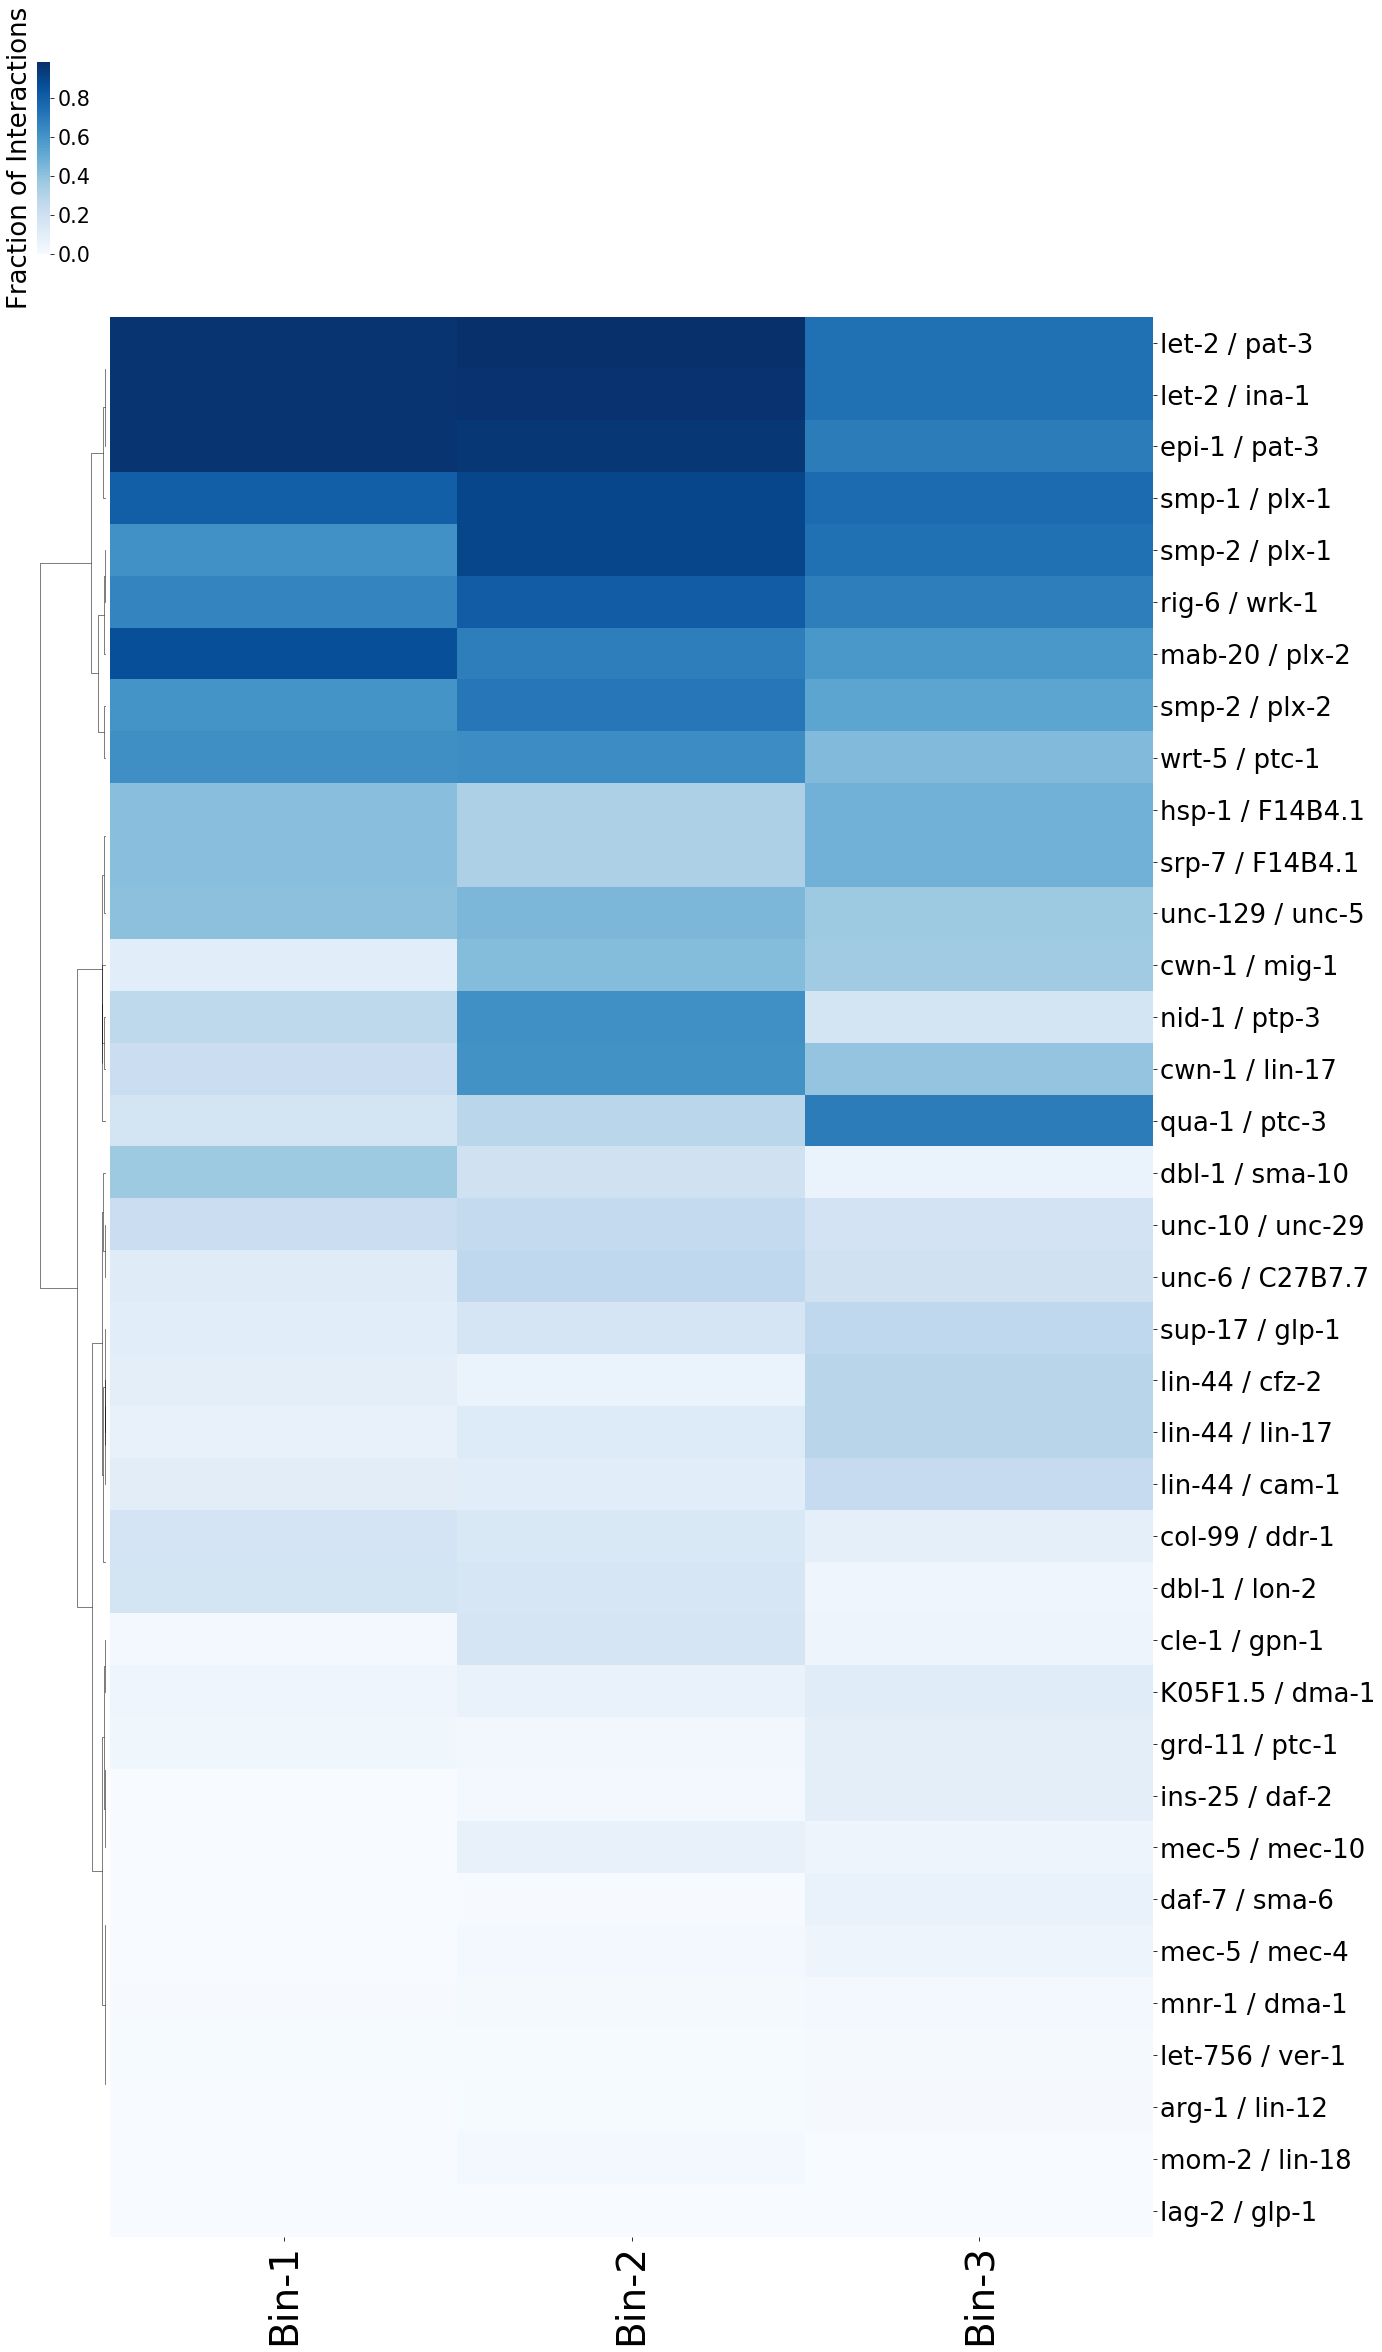

In [52]:
fontsize = 26


X = spatial_lr[(spatial_lr.T != 0).any()]
D = pairwise_distances(X)

row_Z = hc.linkage(D, method='ward')
opt_row_Z = hc.optimal_leaf_ordering(row_Z, D)

fig = sns.clustermap(X,
                     col_cluster=False,
                     row_linkage=opt_row_Z,
                     cmap='Blues',
                     figsize = (20,40)
                    )

fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.yaxis.get_majorticklabels(),
                               rotation=0,
                               ha='left', 
                               fontsize=fontsize)
fig.ax_heatmap.set_xticklabels(fig.ax_heatmap.xaxis.get_majorticklabels(),
                               rotation=90,
                               fontsize=fontsize*1.5)

cbar = fig.ax_heatmap.collections[0].colorbar
cbar_label = 'Fraction of Interactions'#'# Interactions / Total Interactions'
cbar.ax.set_ylabel(cbar_label, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize*0.8)
cbar.ax.yaxis.set_label_position("left")

plt.savefig('../Figures/Spatial-LRs.svg',
            dpi=300,
            bbox_inches='tight')

In [53]:
# LRs that are not used
spatial_lr[~(spatial_lr.T != 0).any()].index

Index([], dtype='object')

In [54]:
-1*np.log(0.05)

2.995732273553991

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/ipykernel_launcher.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # This is added back by InteractiveShellApp.init_path()
/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/ipykernel_launcher.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if sys.path[0] == '':


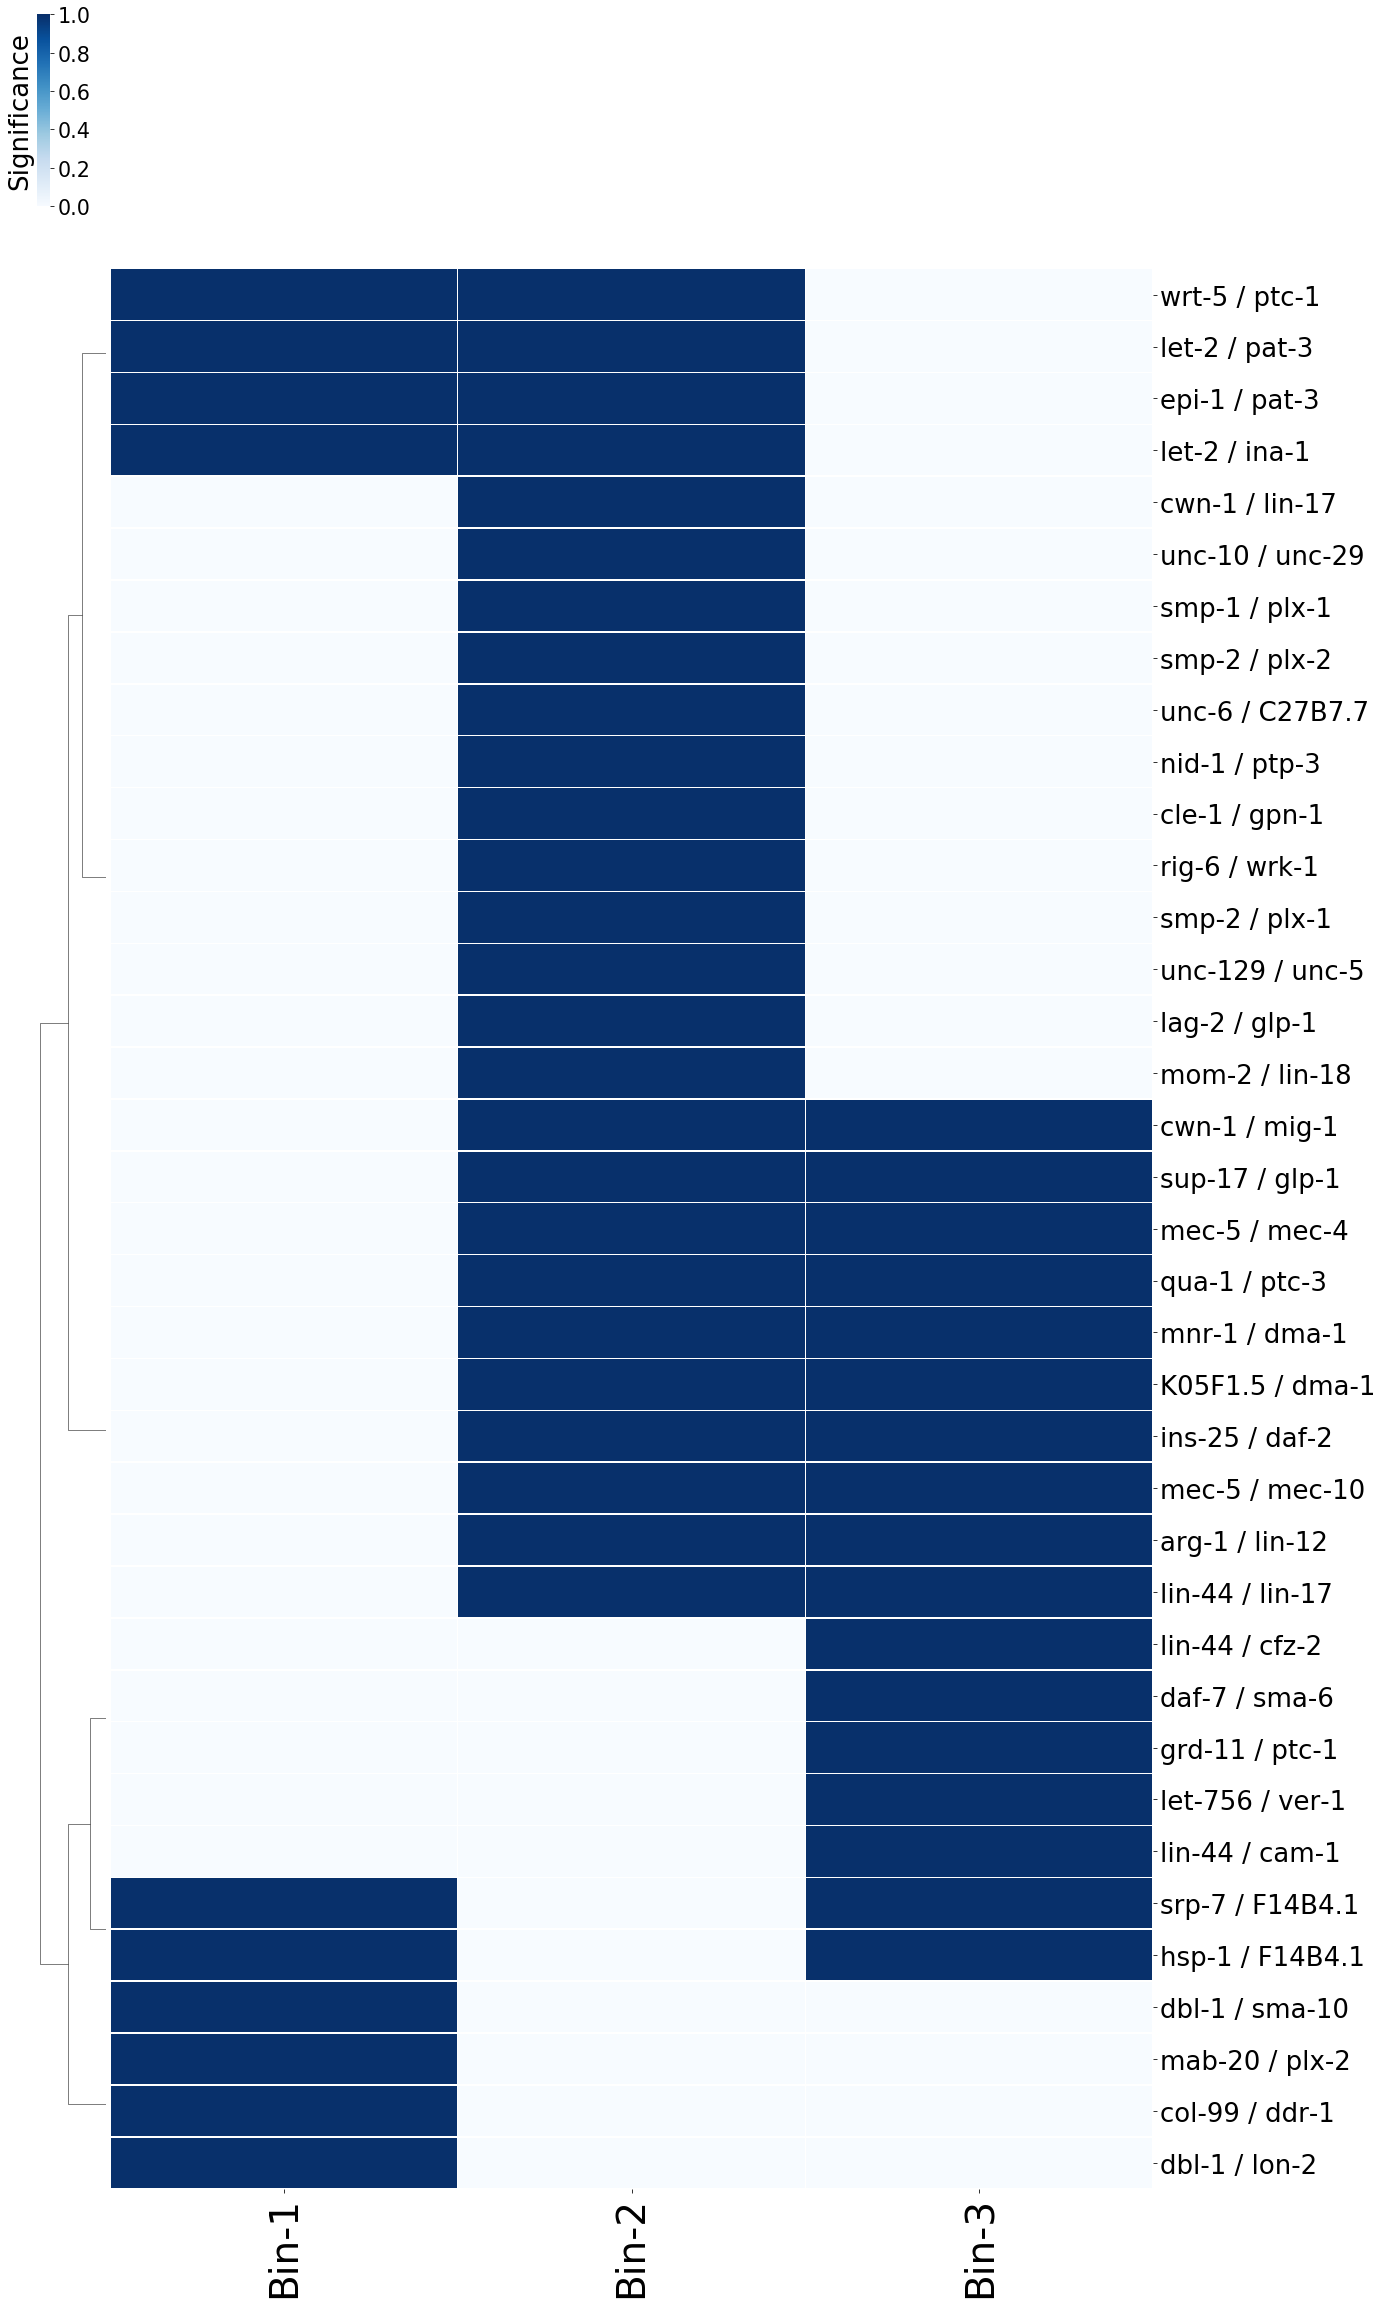

In [55]:
fontsize = 26


X = spatial_pvals[(spatial_lr.T != 0).any()].values
if raw_pval == False:
    D = pairwise_distances(X, metric='cosine')
else:
    D = pairwise_distances(X)
X = spatial_pvals[(spatial_lr.T != 0).any()]

row_Z = hc.linkage(D, method='ward')
opt_row_Z_2 = hc.optimal_leaf_ordering(row_Z, D)

fig2 = sns.clustermap(X,
                      col_cluster=False,
                      row_linkage=opt_row_Z_2,
                      cmap='Blues',
                      figsize = (20,40),
                      linewidths=.5
                     )

fig2.ax_heatmap.set_yticklabels(fig2.ax_heatmap.yaxis.get_majorticklabels(),
                                rotation=0,
                                ha='left', 
                                fontsize=fontsize)
fig2.ax_heatmap.set_xticklabels(fig2.ax_heatmap.xaxis.get_majorticklabels(),
                                rotation=90,
                                fontsize=fontsize*1.5)

cbar2 = fig2.ax_heatmap.collections[0].colorbar
if raw_pval == False:
    cbar_label = 'Significance'
else:
    cbar_label = '$-log_{10}$(q-value)'
cbar2.ax.set_ylabel(cbar_label, fontsize=fontsize)
cbar2.ax.tick_params(labelsize=fontsize*0.8)
cbar2.ax.yaxis.set_label_position("left")

plt.savefig('../Figures/Spatial-LRs-Enr-pvals.svg',
            dpi=300,
            bbox_inches='tight')

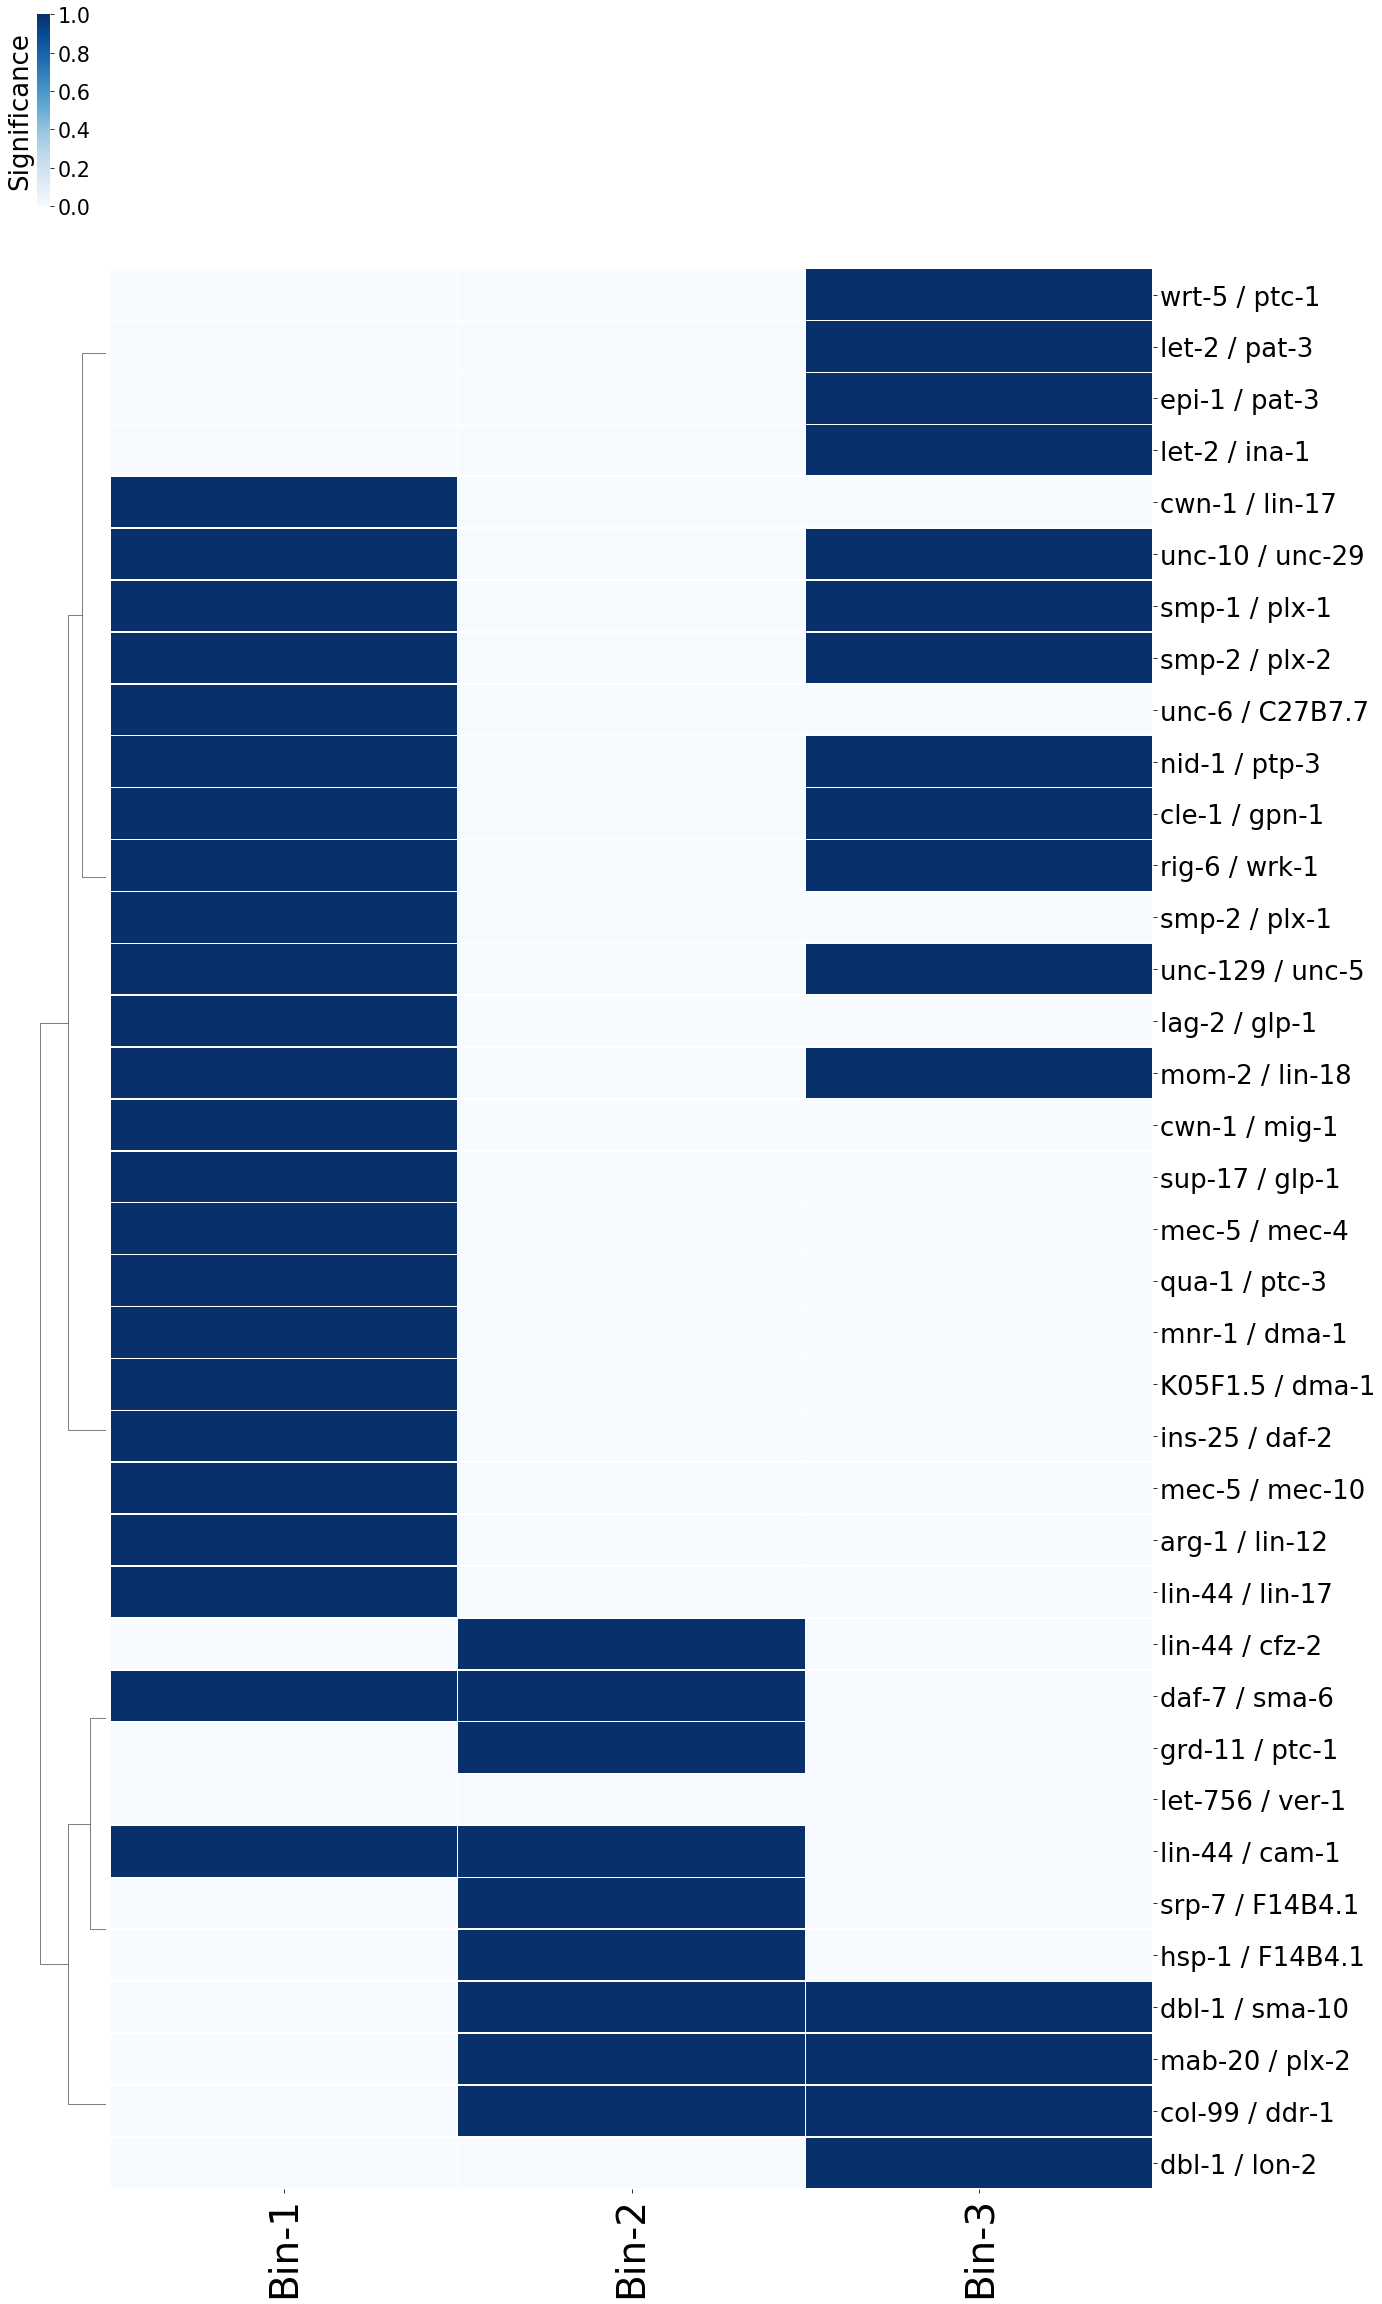

In [56]:
fontsize = 26


X = spatial_pvals2[(spatial_lr.T != 0).any()]

fig2 = sns.clustermap(-1*X,
                      col_cluster=False,
                      row_linkage=opt_row_Z_2,
                      cmap='Blues',
                      figsize = (20,40),
                      linewidths=.5
                     )

fig2.ax_heatmap.set_yticklabels(fig2.ax_heatmap.yaxis.get_majorticklabels(),
                                rotation=0,
                                ha='left', 
                                fontsize=fontsize)
fig2.ax_heatmap.set_xticklabels(fig2.ax_heatmap.xaxis.get_majorticklabels(),
                                rotation=90,
                                fontsize=fontsize*1.5)

cbar2 = fig2.ax_heatmap.collections[0].colorbar
if raw_pval == False:
    cbar_label = 'Significance'
else:
    cbar_label = '$-log_{10}$(q-value)'
cbar2.ax.set_ylabel(cbar_label, fontsize=fontsize)
cbar2.ax.tick_params(labelsize=fontsize*0.8)
cbar2.ax.yaxis.set_label_position("left")

plt.savefig('../Figures/Spatial-LRs-Dep-pvals.svg',
            dpi=300,
            bbox_inches='tight')

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/ipykernel_launcher.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # This is added back by InteractiveShellApp.init_path()
/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/ipykernel_launcher.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if sys.path[0] == '':


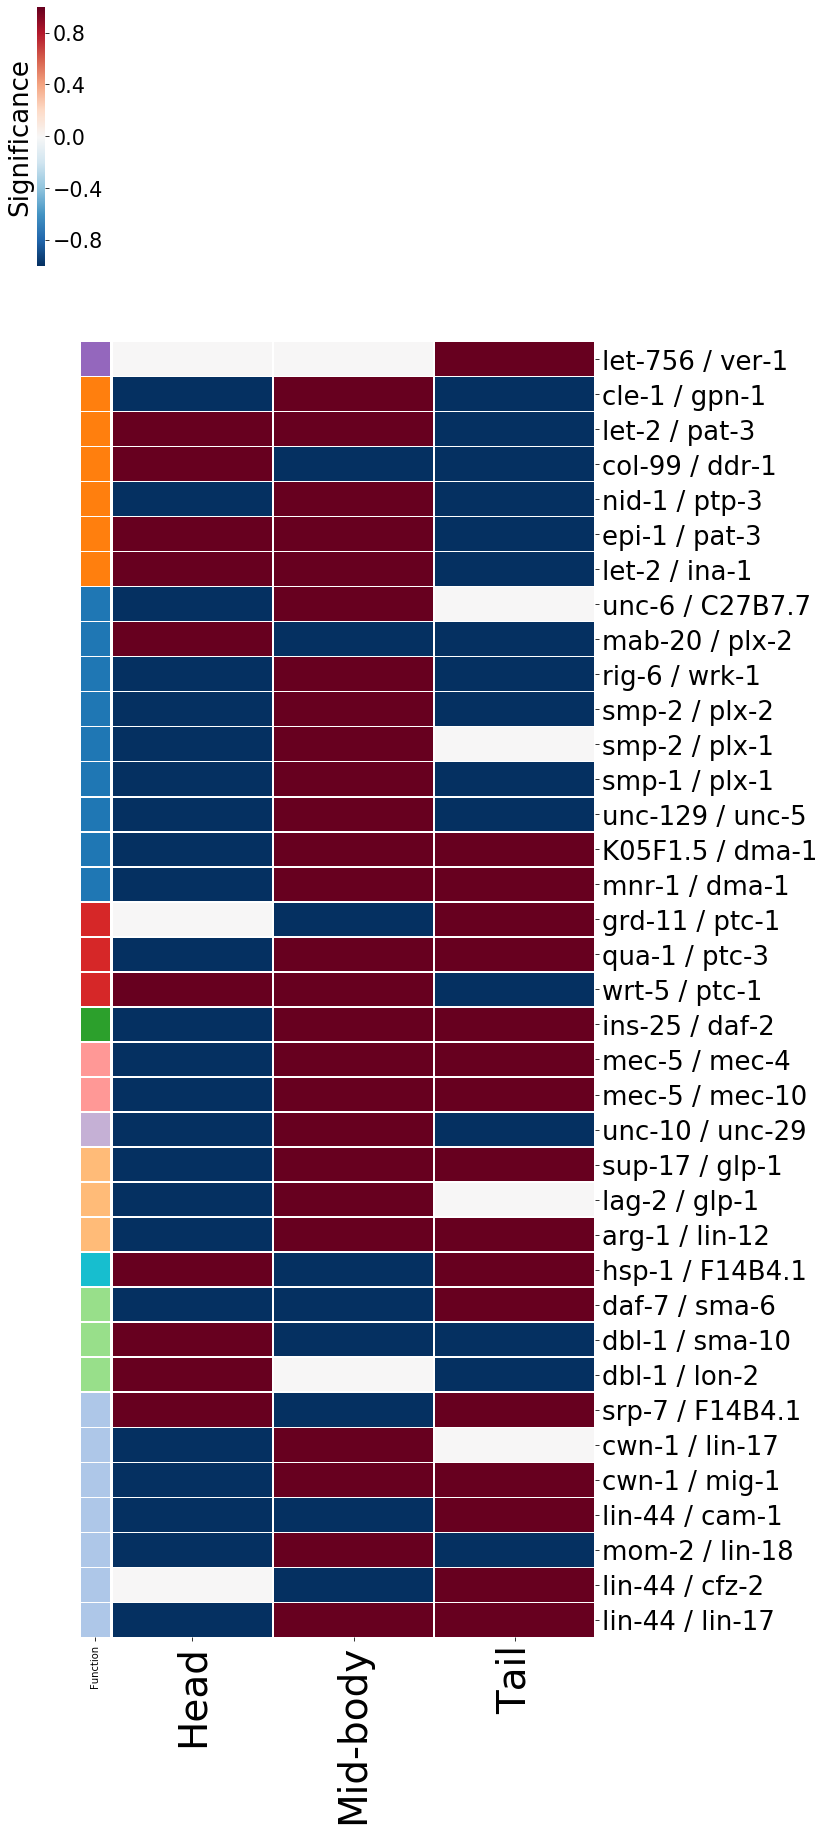

In [61]:
fontsize = 26


X = spatial_pvals + spatial_pvals2
X = X[(X.T != 0).any()]
if raw_pval == False:
    D = pairwise_distances(X, metric='cosine')
else:
    D = pairwise_distances(X)

row_Z = hc.linkage(D, method='ward')
opt_row_Z_2 = hc.optimal_leaf_ordering(row_Z, D)

X.columns = [idx_map[idx] for idx in X.columns]
fig2 = sns.clustermap(X,
                      col_cluster=False,
                      row_cluster=False,
                      row_linkage=opt_row_Z_2,
                      cmap='RdBu_r',
                      figsize = (10,30),
                      linewidths=.5,
                      row_colors=row_cols
                     )

fig2.ax_heatmap.set_yticklabels(fig2.ax_heatmap.yaxis.get_majorticklabels(),
                                rotation=0,
                                ha='left', 
                                fontsize=fontsize)
fig2.ax_heatmap.set_xticklabels(fig2.ax_heatmap.xaxis.get_majorticklabels(),
                                rotation=90,
                                fontsize=fontsize*1.5)

cbar2 = fig2.ax_heatmap.collections[0].colorbar
if raw_pval == False:
    cbar_label = 'Significance'
else:
    cbar_label = '$-log_{10}$(q-value)'
cbar2.ax.set_ylabel(cbar_label, fontsize=fontsize)
cbar2.ax.tick_params(labelsize=fontsize*0.8)
cbar2.ax.yaxis.set_label_position("left")

plt.savefig('../Figures/Spatial-LRs-EnrDep-pvals.svg',
            dpi=300,
            bbox_inches='tight')

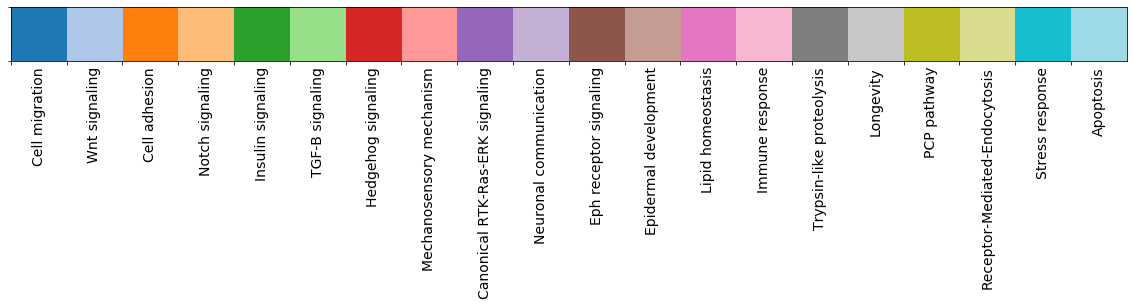

In [58]:
ax = sns.palplot(function_colors.values())
for i, text in enumerate(function_colors.keys()):
    plt.text(i, 0.6, text, rotation=90, horizontalalignment='center', verticalalignment='top',fontsize=14)
    
plt.savefig('../Figures/Spatial-LR-Functions.svg',
            dpi=300,
            bbox_inches='tight')